<a href="https://colab.research.google.com/github/stevegbrooks/big-portfolio-learner/blob/big-data/big_portfolio_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 545 Final Project

## Big Portfolio Learner

### Team members: Steven Brooks & Chenlia Xu

In [ ]:
import random
import numpy as np 
import json
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os

## If statsmodels not the latest version uncomment the following:
#!pip install statsmodels --upgrade
## If boto3 not already installed uncomment the following:
#!pip3 install boto3

from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 8

In [ ]:
import boto3
from botocore import UNSIGNED

from botocore.config import Config

s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
s3.Bucket('cis545project').download_file('data/stock_data.zip', 'stock_data.zip')

In [ ]:
%%capture

in_dir = "stock_data"
if not os.path.exists(in_dir):
  os.makedirs(in_dir)
!unzip /content/stock_data.zip -d /content/$in_dir
!rm -f $in_dir/.gitempty


tech_dir = "technical_data"
if not os.path.exists(tech_dir):
  os.makedirs(tech_dir)
!unzip /content/technical_data.zip -d /content/$tech_dir
!rm -f $tech_dir/.gitempty

# Section 1: Exploratory Data Analysis

The schema of the stock price data is as below:

In [ ]:
stock_data_files = os.listdir(in_dir)

# head of a random file
pd.read_csv(os.path.join(in_dir, stock_data_files[random.randrange(len(stock_data_files))])).head(5)

,symbol,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,WSBC,2021-12-03,34.50,34.598,33.46,33.59,33.59,304460,0.0,1.0
1,WSBC,2021-12-02,33.17,34.470,32.95,34.27,34.27,393982,0.0,1.0
2,WSBC,2021-12-01,33.37,33.875,32.87,32.95,32.95,473915,0.0,1.0
3,WSBC,2021-11-30,32.33,32.990,32.13,32.55,32.55,354607,0.0,1.0
4,WSBC,2021-11-29,33.84,33.840,32.83,32.90,32.90,308771,0.0,1.0


## Step 1: Inspect the data

First look at the number of rows of data across within each year for each stock.  

The function below adds year and month columns to the dataset.

In [ ]:
def add_year_month_cols(df: pd.DataFrame, timestamp_col: str) -> pd.DataFrame:
  """ 
  Assumes the input df has a column that needs to be converted into datetime
  using datetime.strptime function and "%Y-%m-%d" format
  """
  new_col_name = timestamp_col + '_as_dt'
  df[new_col_name] = df[timestamp_col].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
  if len(df[new_col_name].unique()) != len(df[timestamp_col].unique()):
    raise Exception("error in timestamp parsing")
  df['year'] = pd.to_numeric(df[new_col_name].dt.year)
  df['month'] = pd.to_numeric(df[new_col_name].dt.month)
  return df

Here we calculate how many rows of data per year there are for each stock. Each row corresponds to a trading day.

In [ ]:
rows_per_year = dict()

for data_file in stock_data_files:
  stock_data = pd.read_csv(os.path.join(in_dir, data_file))
  stock_data = add_year_month_cols(stock_data, "timestamp")
  rows_per_year[data_file] = dict(stock_data.groupby(by = 'year').size())

{'SRZNW.csv': {2021: 80}, 'USPH.csv': {1999: 43, 2000: 252, 2001: 248, 2002: 252, 2003: 252, 2004: 252, 2005: 252, 2006: 251, 2007: 251, 2008: 253, 2009: 252, 2010: 252, 2011: 252, 2012: 250, 2013: 252, 2014: 252, 2015: 252, 2016: 252, 2017: 251, 2018: 251, 2019: 252, 2020: 253, 2021: 233}, 'EVT.csv': {2003: 67, 2004: 252, 2005: 252, 2006: 251, 2007: 251, 2008: 253, 2009: 252, 2010: 252, 2011: 252, 2012: 250, 2013: 252, 2014: 252, 2015: 252, 2016: 252, 2017: 251, 2018: 251, 2019: 252, 2020: 253, 2021: 233}}


#### We'll just look at the data from the years we are interested in: 2002 to 2019, inclusive.

In [ ]:
analysis_years = range(2002, 2020)

27 stocks have data in each of the years in range(2002, 2020)
There are 4 unique rows-per-year patterns among those stocks


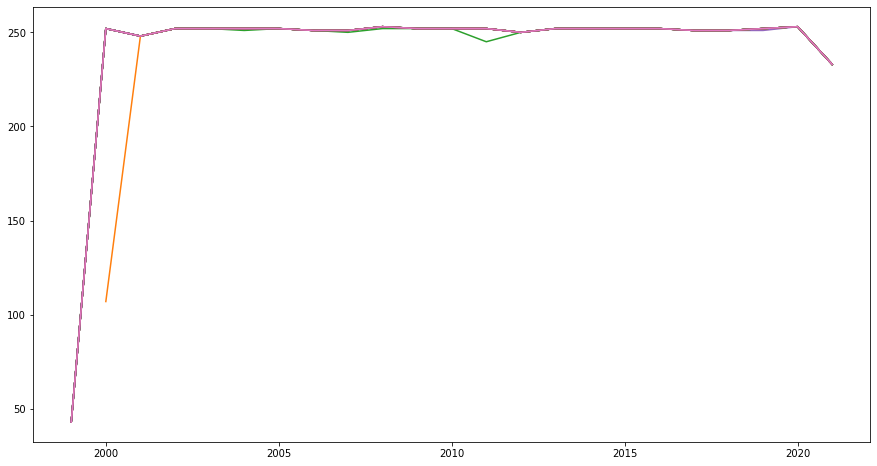

In [ ]:
count_unique = 1
stocks_with_all_analysis_yrs = []
last = None

for i, (key, rows_dict) in enumerate(rows_per_year.items()):
  if all(analysis_year in rows_dict for analysis_year in analysis_years):
    stocks_with_all_analysis_yrs.append(key)
    if last is None: last = rows_dict
    elif rows_dict != last: count_unique += 1
    as_list = sorted(rows_dict.items())
    year, row_count = zip(*as_list)
    plt.plot(year, row_count)

print(len(stocks_with_all_analysis_yrs), "stocks have data in each of the years in", analysis_years)
print("There are", count_unique, "unique rows-per-year patterns among those stocks")

## Step 2: Visualize the time series data of adjusted closing price per day over this span.

In [ ]:
combined_data = []
for i, data_file in enumerate(stocks_with_all_analysis_yrs):
  stock_data = pd.read_csv(os.path.join(in_dir, data_file))
  stock_data = add_year_month_cols(stock_data, "timestamp")
  stock_data = stock_data[stock_data.year.isin(analysis_years)]
  stock_data.reset_index(inplace = True)
  combined_data.append(stock_data)

combined_data = pd.concat(combined_data)
combined_data.drop(columns = "index", inplace = True)
combined_data.head(5)

,symbol,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,timestamp_as_dt,year,month
0,USPH,2019-12-31,113.40,115.01,113.24,114.35,112.408365,122341,0.0,1.0,2019-12-31,2019,12
1,USPH,2019-12-30,113.98,114.16,112.30,113.86,111.926685,72785,0.0,1.0,2019-12-30,2019,12
2,USPH,2019-12-27,114.10,114.10,113.02,114.00,112.064308,78205,0.0,1.0,2019-12-27,2019,12
3,USPH,2019-12-26,115.22,116.69,113.25,113.98,112.044648,73688,0.0,1.0,2019-12-26,2019,12
4,USPH,2019-12-24,114.64,115.79,113.41,115.54,113.578159,30642,0.0,1.0,2019-12-24,2019,12


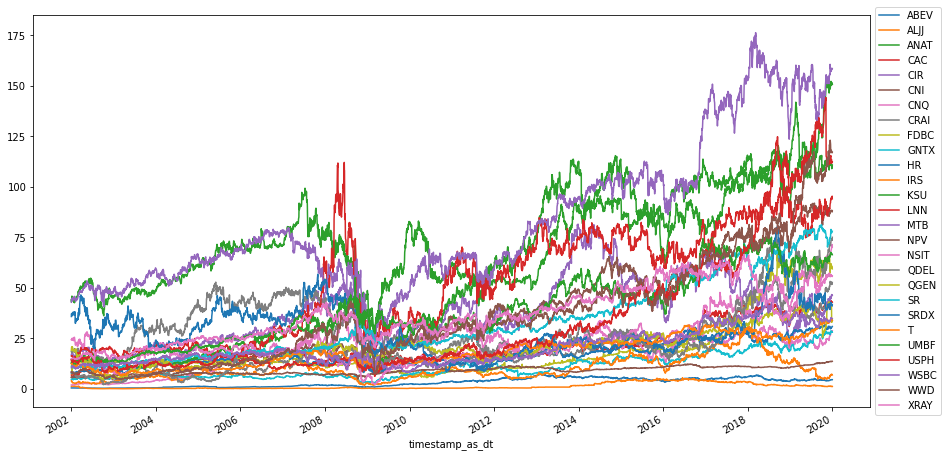

In [ ]:
fig, ax = plt.subplots()

for key, data in combined_data.groupby('symbol'):
  data.plot( x='timestamp_as_dt', y='adjusted_close', ax=ax, label=key)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

This plot clearly shows us that stock data over time is non-stationary. At the very least, the mean increases with time, but also the variance of the series appears time depenedent. However, the covariance *appears* to be constant with time.

#### Check if there is any seasonality trends by month

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


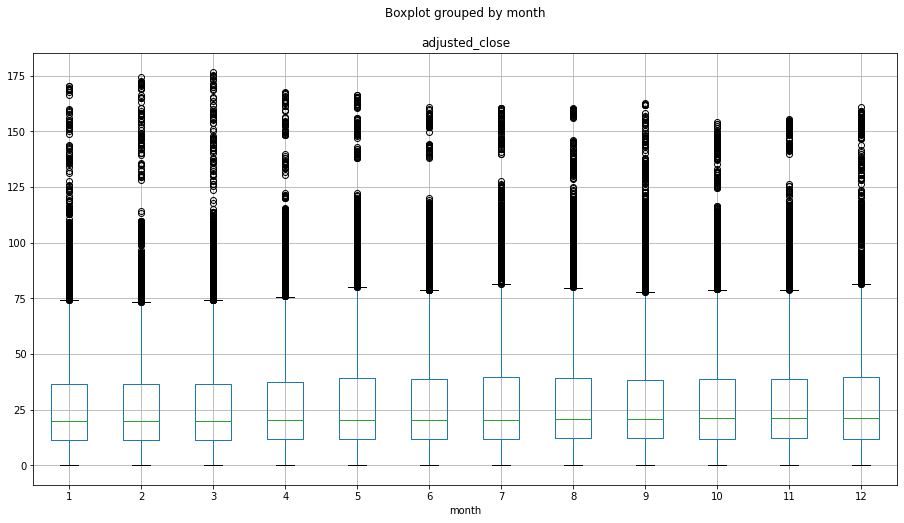

In [ ]:
sns.boxplot(x = 'adjusted_close', y = 'month', orient = 'h', palette = 'pastel', data = combined_data)

Looks like there are no seasonal trends.

# Section 2: Split the dataset

Our approach will be to create a training and validation set from 80% of the data, and hold 20% back as a test set for final evaluation of the model.

In [ ]:
%%spark

train = combined_data



# Section 3: Develop a naîve time series model to form a baseline.

This model will only look at the daily adjusted close price data and time.

Before we run the model, we'll have to stationarize our time series data.

We will use differencing and a log transform to take out the trends and stabilize the variance in the data (i.e., make it stationary).

In [ ]:
combined_data = combined_data.sort_values(by = ['symbol', 'timestamp_as_dt'])

combined_data['adjusted_close_log'] = np.log(combined_data['adjusted_close'])

combined_data['adjusted_close_log_diff'] = combined_data.groupby('symbol')['adjusted_close_log'].diff()

combined_data.reset_index(inplace = True)
combined_data.dropna(inplace = True)

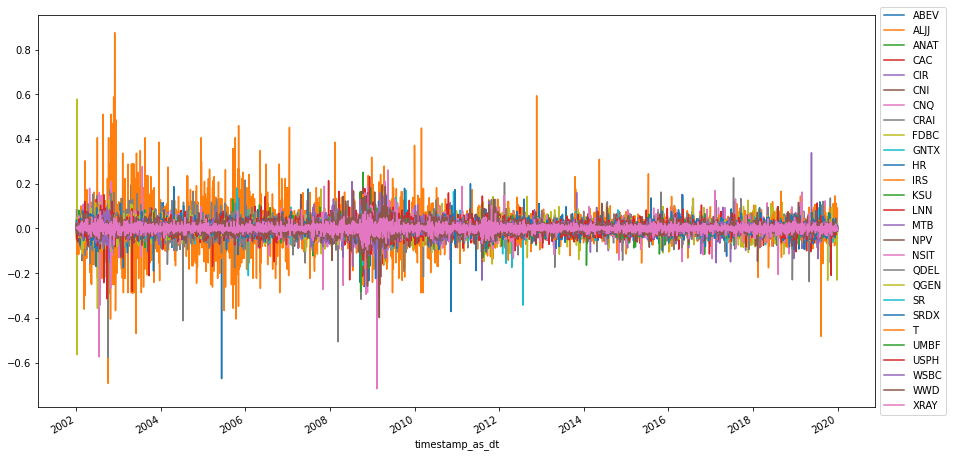

In [ ]:
fig, ax = plt.subplots()

for key, data in combined_data.groupby('symbol'):
  data.plot(x='timestamp_as_dt', y='adjusted_close_log_diff', ax=ax, label=key)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We will now look at the Autocorrelation plots to see which parameters we need to use in our time series model.

Stock data is typically an Autoregressive time series with lag of 1, but we will use the ACF and PACF plots to check what the optimal lag parameter is.

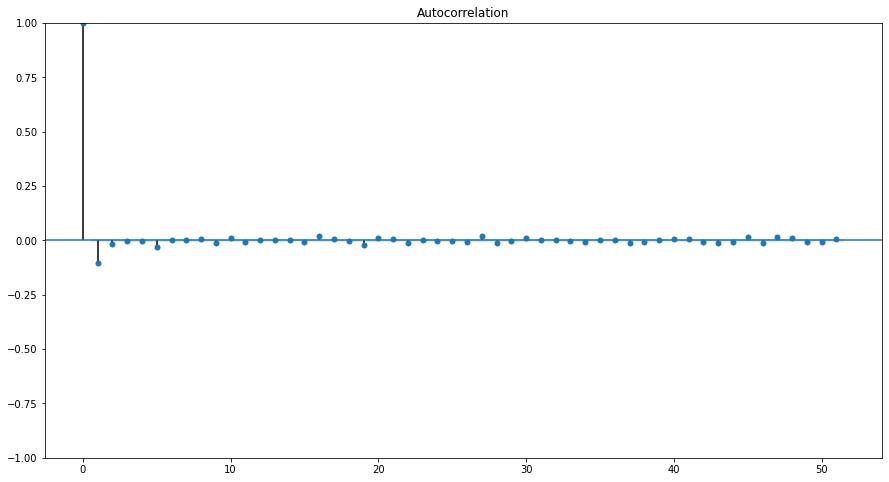

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
_ = plot_acf(combined_data['adjusted_close_log_diff'])

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


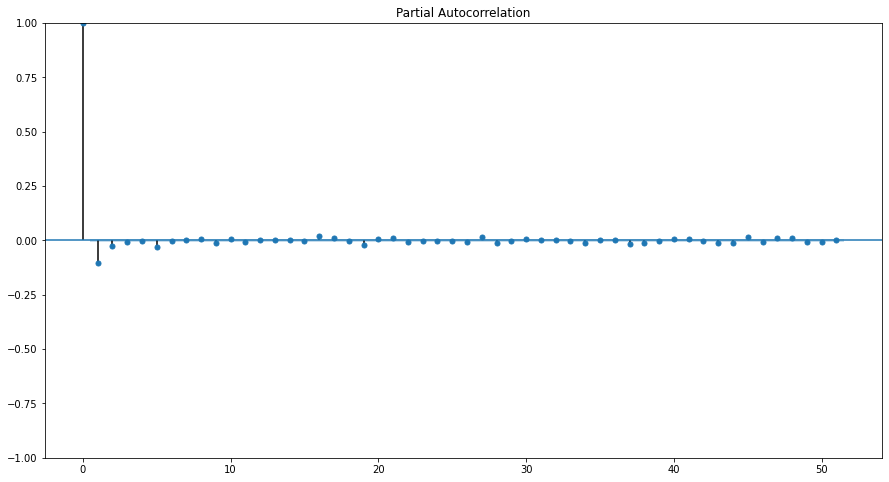

In [ ]:
_ = plot_pacf(combined_data['adjusted_close_log_diff'])

Looks like it is indeed an AR(1) process.

We will fit a simple AutoRegressive model to the stock data and predict the next day's price.

Finally, we will rank the stocks in descending order based on the difference between the predicted price (T0 + 1) and the most recent price in the data (T0).

This model will serve as a baseline for a more sophisticated model.

<BarContainer object of 27 artists>

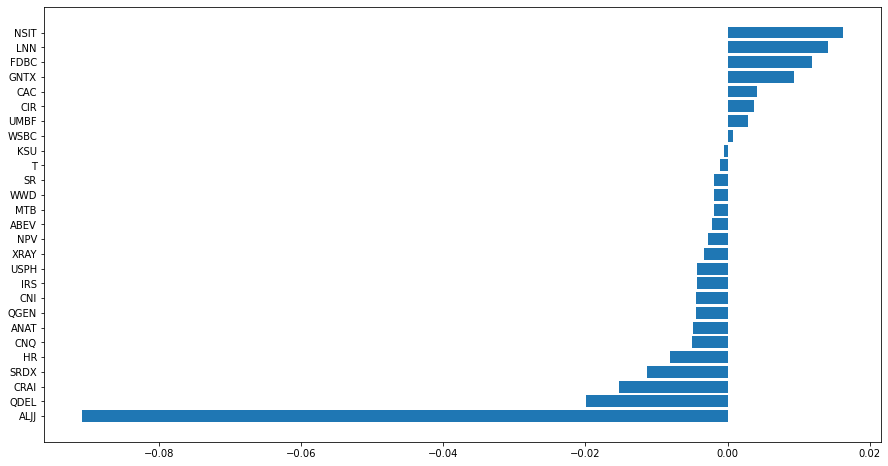

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict

diffs = OrderedDict()
for symbol in combined_data.symbol.unique():
  ts_data = combined_data[combined_data.symbol == symbol][['timestamp_as_dt', 'adjusted_close_log']]
  ts_data.set_index('timestamp_as_dt', inplace = True)

  res = AutoReg(ts_data, [1]).fit()
  predicted = res.predict(end = ts_data.shape[0])
  diffs[symbol] = predicted[ts_data.shape[0] - 1] - predicted[ts_data.shape[0]]

diffs = OrderedDict(sorted(diffs.items(), key=lambda t: t[1]))

lists = diffs.items()
lists 
x, y = zip(*lists)

plt.barh(x, y)

## Evaluate naîve model

# Section 4: Improve on the naîve baseline model.

This section will hope to improve on the model above by incorporating exogenous variables.